# Extreme Value Analysis 2 (Solution)

## Objective

Fit the adequate parametric continuous distribution function for the identified extreme observations and assess its goodness of fit.

## Introduction

Once the extreme observation of our loading variables are sampled for the historical database, we can adress the fitting of the parametric distribution which will allow us to infer the needed extreme values, although we may not have observed them yet. We will follow the next steps:

0. Load libraries, data and run previously developed code
1. Calculating the empirical distribution function 
2. Fitting the Generalized Extreme Value parametric distribution
3. Assessing goodness of fit

## 0. Load libraries, data and run previously developed code

Install dependences if needed

In [ ]:
#!pip install --upgrade pandas numpy scipy statsmodels matplotlib datetime
%matplotlib inline

Import necessary libraries (include more if needed).

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import datetime

We are going to use the same dataset as Wednesday. Here, we are going to import it from our local folder directly. Ensure that the file "Buoy.csv" is located in the same folder that your notebook.

In [2]:
data = pd.read_csv("Buoy.csv", sep = ';')
data.head()

,Date (GMT),Hs(m)
0,1985 09 24 21,0.22
1,1985 09 25 21,0.46
2,1985 09 26 00,0.73
3,1985 09 26 03,0.72
4,1985 09 26 06,0.75


We saw in the previous notebook that we needed to give the first column an appropriate format and remove mistaken measurements of the buoy. Remember that the first column of the database corresponds to the date and time of each measurement, while the second column corresponds to the hourly measured significant wave height ($H_s$).

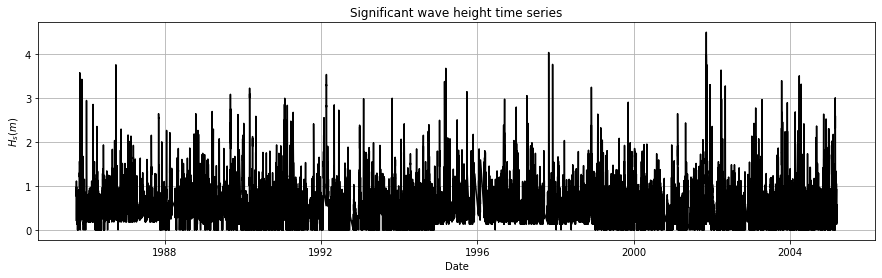

In [3]:
data['Date (GMT)'] = pd.to_datetime(data['Date (GMT)'])

data = data[data['Hs(m)'] >= 0]

data.set_axis([np.linspace(0, len(data)-1, len(data), dtype=int)], axis='index', inplace=True)
fig, axs=plt.subplots(1, 1)
axs.plot(data['Date (GMT)'], data['Hs(m)'], 'k', label='${H_s(m)}$')
axs.set_title('Significant wave height time series')
axs.set_xlabel('Date')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(15, 4)
axs.grid()

In the previous notebook, you also developed a code to sample extreme observations using Yearly Maxima.

**Task #0: Go back to the previous notebook on Extreme Value Analysis and get the function to perform yearly maxima. Apply it to the buoy data.**

In [4]:
def yearly_maxima(data):
    idx_max = data.groupby(pd.DatetimeIndex(data['Date (GMT)']).year)['Hs(m)'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

yearly_maxima_list = yearly_maxima(data)
yearly_maxima_list

,Date (GMT),Hs(m)
230,1985-10-28 02:00:00,3.57
2481,1986-09-30 18:00:00,3.75
4724,1987-11-03 21:00:00,2.64
6168,1988-10-16 19:00:00,2.64
7957,1989-09-05 17:00:00,3.08
10237,1990-03-03 22:00:00,3.22
16649,1991-01-26 14:00:00,2.99
22659,1992-02-20 02:00:00,3.53
35113,1993-10-27 04:00:00,2.99
37723,1994-02-16 19:00:00,2.41


And we are ready to go with further steps on Extreme Value Analysis!

## 1. Calculating the empirical distribution function

Before fitting a parametric distribution, we need to calculate the empirical distribution function from the identified extreme observations.

**Task #1: Calculate the empirical cumulative distribution function**. Define a function which calculates the cumulative empirical distribution function from data. The function must take as input the identified extremes. The output of the function must be a dataframe with two columns: F_x and Hs(m).

*Important: you have to code the function yourself, not used a prebuilt function from a package.*

*Suggested steps*:
- Sort the observations of the variable
- Calculate the length (size) of your observations, *n*
- Assign non-exceedance probabilities to each observation, *p=i/(n+1)*, where *i* is the rank
- Store the probabilities and sorted observations in a DataFrame using: 

`ecdf = pd.DataFrame({'F_x':p_data, 'Hs(m)':sorted_data})`

where p_data are the probabilities and sorted_data your sorted observations.

In [5]:
def calculate_ecdf(data):
    sorted_data = np.sort(data) 
    n_data = sorted_data.size 
    p_data = np.arange(1, n_data+1) / (n_data +1)
    ecdf = pd.DataFrame({'F_x':p_data, 'Hs(m)':sorted_data})
    return ecdf

Let's apply your function to the extremes you sampled using Yearly Maxima.

In [6]:
ecdf = calculate_ecdf(yearly_maxima_list['Hs(m)'])
ecdf.head()

,F_x,Hs(m)
0,0.045455,1.95
1,0.090909,2.41
2,0.136364,2.64
3,0.181818,2.64
4,0.227273,2.90


Let's see how it looks!

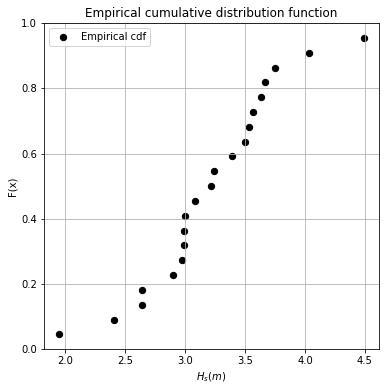

In [7]:
fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['Hs(m)'], ecdf['F_x'], 40, 'k', label = 'Empirical cdf')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 2. Fitting the Generalized Extreme Value parametric distribution

Once we have the empirical cumulative distribution function, we can fit a parametric distribution function.

But first a quick refresher on what you saw in the theoretical videos. We are interested in modelling the stochastic behavior of the maximum values within a sequence $X_1, X_2, ..., X_n$, namely $M_n=max(X_1, X_2, ..., X_n)$.

For large n, the distribution function of $M_n$ converges to $G(x)$, which belongs to the Generalized Extreme Value (GEV) family distribution, regardless the original distribution of X.

Therefore, we have to fit a GEV distribution to the our set of extreme observations.

**Task #2: fit a GEV distribution to the extreme observations obtained with Yearly Maxima**. Define a function which fits the GEV distribution to the empirical distribution function previously obtained, using Maximum Loglikelihood. The set of extreme observations must be the input. The output of the function must be a list with the fitted parameters.

*Hint: Use SciPy library. You can go to the documentation [here](https://docs.scipy.org/doc/scipy/).*

In [8]:
def fit_GEV(data): 
    GEV_param = stats.genextreme.fit(data, method = 'mle')
    return GEV_param

Let's apply your function to your data!

In [9]:
GEV_param = fit_GEV(yearly_maxima_list['Hs(m)'])
GEV_param

(0.2746113330720874, 3.0200555115253906, 0.561859765003837)

Let's see how the fit looks!

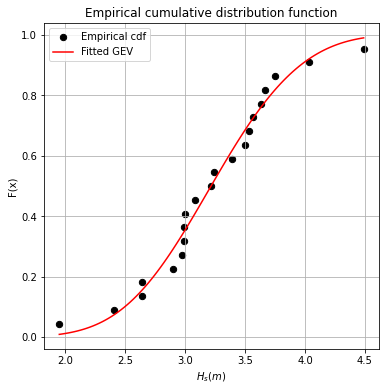

In [10]:
GEV_H = np.linspace(min(yearly_maxima_list['Hs(m)']), max(yearly_maxima_list['Hs(m)']),100)
GEV_p = stats.genextreme.cdf(GEV_H, GEV_param[0], GEV_param[1], GEV_param[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['Hs(m)'], ecdf['F_x'], 40, 'k', label = 'Empirical cdf')
axs.plot(GEV_H, GEV_p, 'r', label = 'Fitted GEV')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

Do you think is a good fit? We will address this question in the next section.

## 3. Assessing goodness of fit

After fitting a parametric distribution function, the same questions always appears: is it a good approximation to my observations? To help us answering this question, we have goodness of fit techniques.

### 3.1. Kolmogorov-Smirnov hypothesis test

As you saw in the videos, Kolmogorov-Smirnov test is a goodness of fit hypothesis test based on the maximum distance between the empirical cumulative distribution function and the parametric distribution function.

**Task #3. Calculate the p-value obtained from the Kolmogorov-Smirnov test to assess the goodness of fit of GEV distribution to the extreme observations. What does it mean assuming a significance level $\alpha=0.05$?**

*Hint: Use Scipy library. You can go to the documentation [here](https://docs.scipy.org/doc/scipy/).*

In [11]:
stats.kstest(ecdf['Hs(m)'], stats.genextreme.ppf(ecdf['F_x'], GEV_param[0], GEV_param[1], GEV_param[2]))

KstestResult(statistic=0.09523809523809523, pvalue=0.9999961038154768)

In [12]:
'''
The obtained p-value is higher than the significance level, so the Kolmogorov-Smirnov test is indicating
that GEV distribution is a good fit to our data
'''

'\nThe obtained p-value is higher than the significance level, so the Kolmogorov-Smirnov test is indicating\nthat GEV distribution is a good fit to our data\n'

### 3.2. Graphical methods

Graphical methods are useful tools, since allow us to represent our data and confirm the results of our analysis at a glance.

QQ-plot is a very common graphical method which compares the empirical quantiles (typically in x-axis) with those obtained using the fitted parametric distribution (typically in y-axis).

**Task #4. Fill the code below to represent the QQ-plot to assess the goodness of fit of GEV distribution to the extreme observations.**

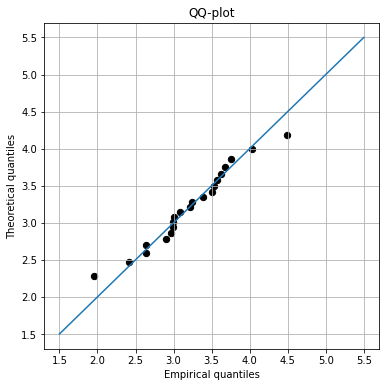

In [13]:
empirical_quantiles = ecdf['Hs(m)']
pred_quantiles = stats.genextreme.ppf(ecdf['F_x'], GEV_param[0], GEV_param[1], GEV_param[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(empirical_quantiles, pred_quantiles, 40, 'k')
axs.plot([1.5, 5.5], [1.5,5.5])
axs.set_title('QQ-plot')
axs.set_ylabel('Theoretical quantiles')
axs.set_xlabel('Empirical quantiles')
fig.set_size_inches(6, 6)
axs.grid()

Another commonly used graphical method is the probability plot or probability paper. In this method, the grid of one axis (typically x-axis) is adapted to a theoretical distribution function, so when that theoretical distribution is plotted, a line is obtained. Considering here the GEV distribution whose equation is

$F(x)=exp\{-[1+\xi \frac{x- \mu}{\sigma}]^{-1/\xi}\}$, being $(1+\xi \frac{x- \mu}{\sigma})>0$

where $\mu, \sigma$ and $\xi$ are the location, scale and shape parameters, respectively. We can see that there is not explicit transformation to obtain a linear relationship between F(x) and $\frac{x- \mu}{\sigma}$. Thus, we will apply Gumbel paper, since the obtained $\xi$ is low, although $\xi \ne 0$. Remember that Gumber distribution is derived from GEV distribution when $\xi \rightarrow 0$, leading to the equation

$F(x)=exp\{-exp[-\frac{x- \mu}{\sigma}]\}$

By rearranging the previous expression, we can reach

$-\ln(-\ln F(x))=\frac{x- \mu}{\sigma}$

which defines the Gumbel probability paper

**Task #5. Fill the code below to represent the Gumbel probability plot to assess the goodness of fit of GEV distribution to the extreme observations.**

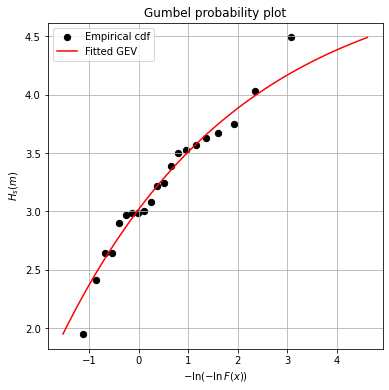

In [14]:
obs_prob_plot_x = -np.log(-np.log(ecdf['F_x']))
obs_prob_plot_y = ecdf['Hs(m)']

theor_prob_plot_x = -np.log(-np.log(GEV_p))
theor_prob_plot_y = GEV_H

fig, axs = plt.subplots(1, 1)
axs.scatter(obs_prob_plot_x, obs_prob_plot_y, 40, 'k', label = 'Empirical cdf')
axs.plot(theor_prob_plot_x, theor_prob_plot_y, 'r', label = 'Fitted GEV')
axs.set_title('Gumbel probability plot')
axs.set_xlabel('$-\ln(-\ln F(x))$')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

### 3.3. Is it a good fit?

Goodness of fit techniques support us in the decision process to determine if a probability distribution is a good approximation to our observations. Now, it is your turn to apply your critical thinking to determine if GEV distribution is a good fit to the extreme observations.

**Task #6. Is GEV distribution a good model for the extreme observations? Explain your answer.**

In [ ]:
'''
Kolmogorov-Smirnov test is indicating us that the GEV distribution fits well our data in general.
However, if we take a look to our graphical methods, we can see that the positive tail may not be that well
represented. Thus, we should be careful when extrapolating to larger values of Hs.
'''